# ДЗ #8. Обучение без учителя. K-means, EM алгоритм <a id="0"></a>

### Датасет: https://archive.ics.uci.edu/ml/datasets/Census+Income

* [Загрузка и подготовка данных](#1)
* [ML](#2)
    * K-Means
    * Инерция
    * Силуэт
    * Иерархическая кластеризация
* [Вывод](#3)

In [1]:
# Импорт основных библиотек
import os
import warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
warnings.filterwarnings("ignore")
np.random.seed(42)

---
<a id="1"></a>
## Загрузка и подготовка данных [(Наверх)](#0) 

In [3]:
url = ['https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data',
       'https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test']
filename = './data/income.csv'
column_names = ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status',
                'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss',
                'hours-per-week', 'native-country', 'income']

if not os.path.exists(filename):
    income_df = pd.concat([pd.read_csv(url[0], names=column_names, skipinitialspace=True, na_values='?'), 
                           pd.read_csv(url[1], names=column_names, skipinitialspace=True, skiprows=1, na_values='?')],
                          sort=False, ignore_index=True)
    income_df.to_csv(filename, index=False)
else:
    income_df = pd.read_csv(filename)

# Проверим корректно ли загружен CSV
income_df

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48837,39,Private,215419,Bachelors,13,Divorced,Prof-specialty,Not-in-family,White,Female,0,0,36,United-States,<=50K.
48838,64,NaN,321403,HS-grad,9,Widowed,NaN,Other-relative,Black,Male,0,0,40,United-States,<=50K.
48839,38,Private,374983,Bachelors,13,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,50,United-States,<=50K.
48840,44,Private,83891,Bachelors,13,Divorced,Adm-clerical,Own-child,Asian-Pac-Islander,Male,5455,0,40,United-States,<=50K.


In [4]:
# Узнаем размер датасета
income_df.shape

(48842, 15)

In [5]:
# Узнаем свойства датасета
income_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             48842 non-null  int64 
 1   workclass       46043 non-null  object
 2   fnlwgt          48842 non-null  int64 
 3   education       48842 non-null  object
 4   education-num   48842 non-null  int64 
 5   marital-status  48842 non-null  object
 6   occupation      46033 non-null  object
 7   relationship    48842 non-null  object
 8   race            48842 non-null  object
 9   sex             48842 non-null  object
 10  capital-gain    48842 non-null  int64 
 11  capital-loss    48842 non-null  int64 
 12  hours-per-week  48842 non-null  int64 
 13  native-country  47985 non-null  object
 14  income          48842 non-null  object
dtypes: int64(6), object(9)
memory usage: 5.6+ MB


In [6]:
# Проверим на дубликаты и удалим если есть
income_df.drop_duplicates(inplace=True)
income_df.duplicated().sum()

0

In [7]:
# Удалим NaN
income_df.dropna(inplace=True)

In [8]:
# Удалим 'education' из нашего датасета и целевую переменную
income_df.drop(['education', 'income'], axis=1, inplace=True)

In [9]:
# Закодируем следующие переменные в новый df
to_dummies = ['workclass', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']
income_1hot_df = pd.get_dummies(income_df, columns=to_dummies)

---
<a id="2"></a>
## ML [(Наверх)](#0) 

In [10]:
# Импортируем библиотеки для ML
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.cluster import KMeans

In [11]:
# Cтандартизируем переменные
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(income_1hot_df)
X_test_scaled = scaler.transform(income_1hot_df)

### K-Means

In [12]:
kmeans = KMeans(n_clusters=5, random_state=24)
kmeans.fit(income_1hot_df)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=24, tol=0.0001, verbose=0)

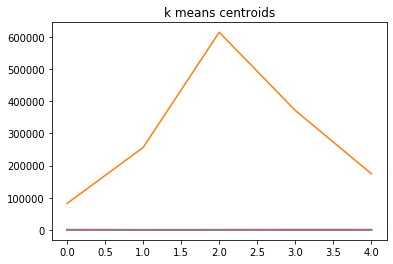

In [58]:
plt.plot(kmeans.cluster_centers_)
plt.title('k means centroids')
plt.show()

На графике четко виден излом на отметке 2. Проверим гипотезу об оптимальном количестве кластеров = 2

### Инерция

Text(0.5, 1.0, 'Метод локтя (оптимальный k)')

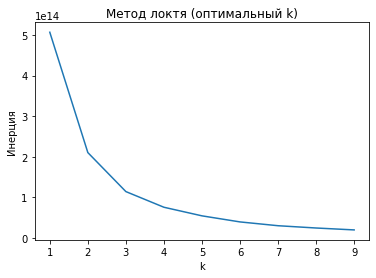

In [62]:
inertia = []
k = range(1, 10)
for k_i in k:
    kmeans = KMeans(n_clusters=k_i).fit(income_1hot_df)
    kmeans.fit(income_1hot_df)
    inertia.append(kmeans.inertia_)
 
plt.plot(k, inertia)
plt.xlabel('k')
plt.ylabel('Инерция')
plt.title('Метод локтя (оптимальный k)')

### Силуэт

[0.5835581200031302, 0.5518597600443531, 0.5549436945382783]


Text(0.5, 1.0, 'The Elbow Method showing the optimal k')

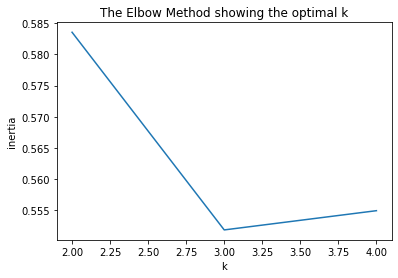

In [14]:
from sklearn.metrics import silhouette_score
inertia = []
k = range(2, 5)
for k_i in k:
    km = KMeans(n_clusters=k_i).fit(income_1hot_df)
    km.fit(income_1hot_df)
    inertia.append(silhouette_score(income_1hot_df, km.labels_))

print(inertia)
    
plt.plot(k, inertia)
plt.xlabel('k')
plt.ylabel('inertia')
plt.title('The Elbow Method showing the optimal k')

Максимальное значение у k=2

### Иерархическая кластеризация

In [61]:
# Снизим размерность с помощью PCA
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
income_principal = pd.DataFrame(pca.fit_transform(income_1hot_df))

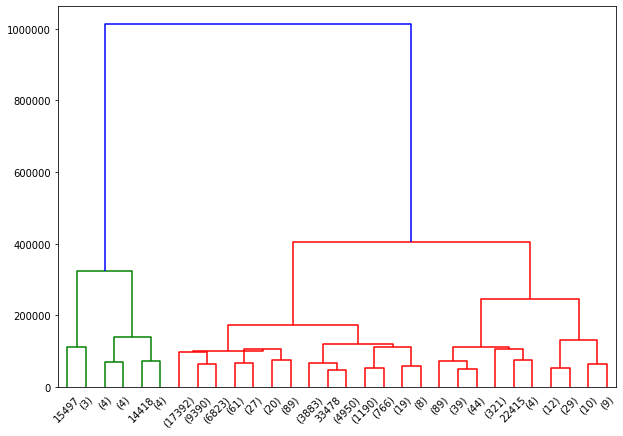

In [19]:
from scipy.cluster.hierarchy import dendrogram, linkage

linked = linkage(income_principal, method='centroid', metric='euclidean')

plt.figure(figsize=(10, 7))
dendrogram(linked,
            orientation='top',
            truncate_mode='lastp')
plt.show()

---
<a id="3"></a>
## Вывод [(Наверх)](#0) 

Оптимальное количество кластеров для данной модели данных равно 2